# Vanilla ABC-SMC 
Set up requrirements and experimental data

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 22 18:22:52 2020

@author: marcofking
"""


import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
from scipy.integrate import odeint
import math
import seaborn as sns
import pandas as pd
#pyabc.settings.set_figure_params('pyabc')  # for beautified plots
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test4.db"))



# Define the ODE to solve 

1) We consider only recontamination from surface contacts, not from additional proliferation of the bacterias on the hands.
$$ y'=(1-\dfrac{y}{C})r-d\exp(-g t)y$$

$C$ is carrying capacity. $d$ is maximum effecicacy. $g$ is decay from the disinfectant.

2) If we wanted to consider proliferation on hands as well as from surface contacts then we could use:
$$ y'=y(1-\dfrac{y}{C})l-d\exp(-g t)y$$

where $l$ is the rate at which microorganisms proliferate on hands. E.g. reproduction.

3) Proliferation and increase from contacts can be combined:
$$ y'=(yl+r)(1-\dfrac{y}{C})-d\exp(-g t)y$$

However with the data we have it is unlikely that we can learn about y and r together.

Currently we only consider the first 4 experimental datapoints as there is a gap which is hard to explain using this model-

Notes: 12th April
- We can first try to fit the model to the data from group 2's washed hand to learn only about $C$ and $r$.
- Then with those learned $C$ and $r$ we can fit the model to the data from group 1's washed hand to learn only about $d$ and $g$. 
- But we never reach a saturation so maybe we shouldn't consider $C$ at all.

In [2]:
#Here we defien the ODE model
def ode_model(contamination,t,r,C,d,g):
    Contamination = contamination;
    return(r*(1-Contamination/C)*Contamination-d*math.exp(-g*t)*Contamination)

#Here we create the input parameters and extract only specific time-points
def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 6
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["r"],parameters["C"],parameters["d"],parameters["g"]))
    #num_at_0=sim[int(precision*0.1/50.0)]
    num_at_1=sim[int(precision*1/tmax)]
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_6=sim[int(precision*6/tmax)]
   # num_at_16=sim[int(precision*16/tmax)]
   # num_at_18=sim[int(precision*18/tmax)]
   # num_at_20=sim[int(precision*20/tmax)]
   # num_at_22=sim[int(precision*22/tmax)]
   # num_at_24=sim[int(precision*24/tmax)]
    #return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]+ sigma*np.random.randn(8)}
    return{"Contamination":[num_at_2,num_at_4,num_at_6]}

# Define the parameter priors

We choose some examples to see how well it works.

In [3]:
parameter_prior = Distribution(r=RV("uniform", 0.0, 200.0),
                               C=RV("uniform", 1000.0, 6000.0),
                               d=RV("uniform", 10.0, 600.0),
                               g=RV("uniform", 2.0, 400.0))

parameter_prior.get_parameter_names()

['C', 'd', 'g', 'r']

# Define the distance fuction
This currently is a absolute distances between the two points divided by the standard deviation at each point. Could use Manhattan distance.

In [4]:
def distance(simulation, data):
    return np.absolute((data["Contamination"] - simulation["Contamination"])/data["sd"]).sum()

# Set up the ABC SMC 


In [5]:
#sigma=0.02
#acceptor = pyabc.StochasticAcceptor()
#kernel = pyabc.IndependentNormalKernel(var=sigma**2)
#eps = pyabc.Temperature()

#abc = pyabc.ABCSMC(deterministic_run, parameter_prior, kernel, eps=eps, acceptor=acceptor,population_size=1000)
#abc.new(db_path,{"Contamination": measurement_data}) #This distance model assumes the name of the predicited and confirmed are the same
#history_acceptor = abc.run(max_nr_populations=5,minimum_epsilon=50000)

In [6]:
# We plug all the ABC options together
from pyabc.populationstrategy import AdaptivePopulationSize


abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=AdaptivePopulationSize(500, 0.15),
    # population_size=1000,
    #transitions=LocalTransition(k_fraction=0.3),
    # eps=MedianEpsilon(500, median_multiplier=0.7),
)

INFO:Sampler:Parallelizing the sampling on 8 cores.


# Setting the observed data

Here we define the initial conditions as well as the observed lab data. 
All ten participants washed their hands for 1 minute with soft soap and then used a paper towel to dry their hands. Participants were then asked to rub their fingertips and thumb for 1 minute.
 time_0 refers to immediatelly after hand hygiene so in reality this might be 5 or 10 minutes after.

In [7]:
#Import experimental data (gerba.data.20200302.csv) from Data
gerba_data = pd.read_csv("../Data/gerba.data.20200302.csv")

#Find mean and standard deviation for each time and treatment type 

gerba_data_mean = gerba_data.groupby(['time','treatment']).mean()
gerba_data_sd = gerba_data.groupby(['time','treatment']).std()

#Sort gerba_data_mean by treatment type and time
gerba_data_mean= gerba_data_mean.sort_values(by=['treatment','time'])
gerba_data_sd = gerba_data_sd.sort_values(by=['treatment','time'])

#print(gerba_data_mean)
#print(gerba_data_sd)

# y_observed is the important piece here: our actual observation.
initial_contamination=1200.0
measurement_data = np.array([134.0,202.0,294.0]) #,400,644,1232,2044,2868
s=np.array([93.70165,86.13942,162.11107])#,116.61904,123.61230,396.88789,628.87201,1147.13556])
precision=5000
measurement_times = np.array([1,2,4,6])#np.arange(len(measurement_data))  
# and we define where to store the results

#This sets up the database and includes the measurement data and standard deviation
history = abc.new(db_path, {"Contamination": measurement_data,"sd":s})

INFO:History:Start <ABCSMC(id=9, start_time=2022-04-12 15:30:38.944190, end_time=None)>


# Running the ABC

In [8]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 314.9709334028981
INFO:ABC:t: 0, eps: 314.9709334028981.
INFO:ABC:Acceptance rate: 500 / 993 = 5.0352e-01, ESS=5.0000e+02.
INFO:Adaptation:Change nr particles 500 -> 3467
INFO:ABC:t: 1, eps: 184.27298627637362.
/Users/marcofking/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
INFO:ABC:Acceptance rate: 3467 / 7725 = 4.4880e-01, ESS=2.4122e+03.
INFO:Adaptation:Change nr particles 3467 -> 2401
INFO:ABC:t: 2, eps: 122.9222425120661.
INFO:ABC:Acceptance rate: 2401 / 5592 = 4.2936e-01, ESS=1.1922e+03.
INFO:Adaptation:Change nr particles 2401 -> 1542
INFO:ABC:t: 3, eps: 93.01423765577691.
/Users/marcofking/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (p

KeyboardInterrupt: 

# Visualise the probability density functions


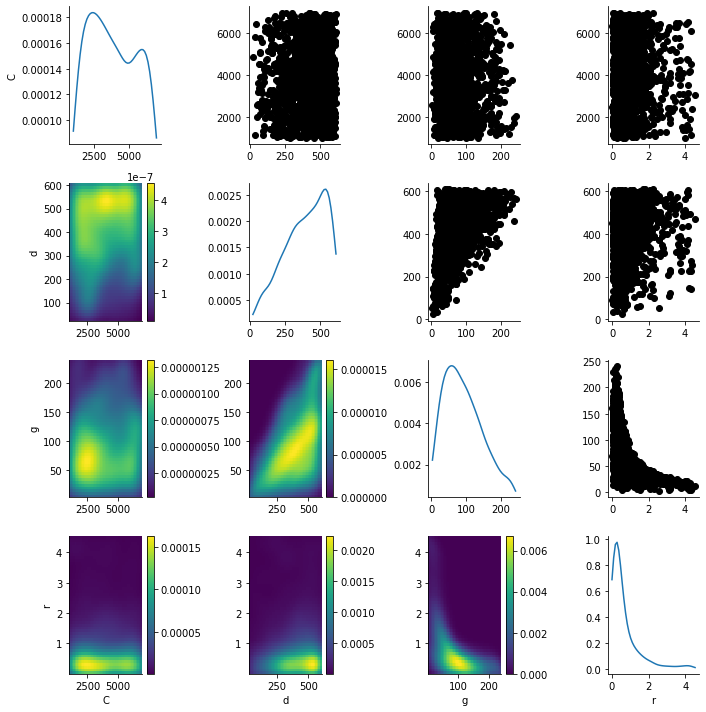

In [9]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

## Visualise how the parameters converge over populations

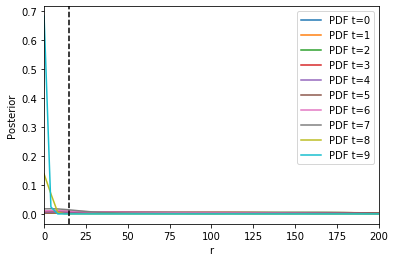

In [15]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=200,
        x="r",
        # xname=r"$\lambda$",
        ax=ax,
        label=f"PDF t={t}",
    )
#Add a vertical line at lambda=0.49 +- 0.32 to 0.72 
#This is the experimental value predicted in King et al. 2020 with Kalanne
ax.axvline(15, color="k", linestyle="dashed")
ax.legend();

# Summary statistics

First some summary statistics and save to file

In [16]:
df.to_csv("../Data/abc_results.csv", encoding='utf-8', index=False)
df.describe()

name,C,d,g,r
count,1447.000000,1447.000000,1447.000000,1447.000000
mean,3891.587433,408.241328,73.013173,0.902821
std,1652.664913,132.141098,46.452379,0.864634
min,1006.563678,22.539693,2.828421,0.001730
25%,2462.835851,321.820425,37.056577,0.284957
50%,3854.191685,429.215235,61.622666,0.627199
75%,5323.240503,517.361027,99.506308,1.234289
max,6988.344754,609.592657,241.286607,4.538883


# Plot some trajectories


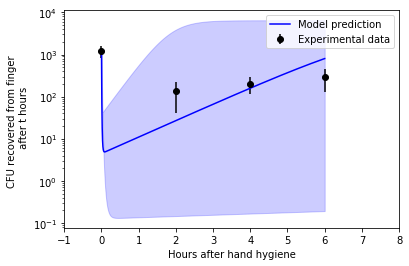

In [17]:
import pandas as pd
import operator


#plot some curves from the ODE model
precision=5000
tmax = 6
time_space = np.linspace(0,tmax,precision+1)#precision+1?

P=odeint(ode_model,initial_contamination,time_space,args=(df["r"].mean(),df["C"].mean(),df["d"].mean(),df["g"].mean()))
Pmin=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.05),df["C"].quantile(0.05),df["d"].quantile(0.05),df["g"].quantile(0.05)))
Pmax=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.95),df["C"].quantile(0.95),df["d"].quantile(0.95),df["g"].quantile(0.95)))

#P=ode_model({"af":df["af"].mean(),"cs":df["cs"].mean(),"lam":df["lam"].mean()})
#Pmin=ode_model({"af":df["af"].quantile(0.05),"cs":df["cs"].quantile(0.05),"lam":df["lam"].quantile(0.05)})
#Pmax=ode_model({"af":df["af"].quantile(0.95),"cs":df["cs"].quantile(0.95),"lam":df["lam"].quantile(0.95)})

# create a vector of values between 0 and 6
x = np.array([0,2,4,6])

#Define new sd just for plotting to avoid SD value at 0
s=np.array([385,93.70165,86.13942,162.11107])
measurement_data = np.array([1200,134.0,202.0,294.0])

#Plot errobars of experimental data
x = np.array([0,2,4,6])
plt.errorbar(x,measurement_data,yerr=s,fmt='o', color='black',label='Experimental data')

#Plot the model prediction
plt.plot(time_space,P,label="Model prediction",color='blue')

#Plot confidence intervals around the model prediction

precision=5000
tmax = 6
time_space = np.linspace(0,tmax,precision+1)

plt.fill_between(time_space,np.concatenate(Pmin),np.concatenate(Pmax),alpha=0.2,color='blue')
#plt.plot(time_space,Pmin,label="Model prediction",color='red')
#plt.plot(time_space,Pmax,label="Model prediction",color='red')

#plt.fill_between(x, np.array(map(operator.sub, P["Contamination"], Pmin["Contamination"])), np.array(map(operator.add, P["Contamination"], Pmax["Contamination"])), color='b', alpha=.1)
plt.xlim(-1,8)
plt.ylabel("CFU recovered from finger \n after t hours")
plt.yscale("log")
plt.xlabel("Hours after hand hygiene")
plt.legend(loc="upper right")
#make y axis logarithmic


#save the plot
plt.savefig("../Images/abc_prediction.png", dpi=600)

plt.show()

In [18]:
#print the shape of time_space
#print(odeint(ode_model,initial_contamination,time_space,args=(df["r"].mean(),df["C"].mean(),df["d"].mean(),df["g"].mean())))

#Print shape of Pmin and time_space
print(Pmin.shape)
print(time_space.shape)

(5001, 1)
(5001,)


In [19]:
#Import experimental data (gerba.data.20200302.csv) from Data
gerba_data = pd.read_csv("../Data/gerba.data.20200302.csv")

#Find mean and standard deviation for each time and treatment type 

gerba_data_mean = gerba_data.groupby(['time','treatment']).mean()
gerba_data_sd = gerba_data.groupby(['time','treatment']).std()

#Sort gerba_data_mean by treatment type and time
gerba_data_mean= gerba_data_mean.sort_values(by=['treatment','time'])
gerba_data_sd = gerba_data_sd.sort_values(by=['treatment','time'])


#for each time row take the conc value from gerba_data_sd and add it to gerba_data_mean
gerba_data_mean['sd'] = gerba_data_sd['conc']

#reanme conc to mean
gerba_data_mean = gerba_data_mean.rename(columns={'conc':'mean'})

#remove Unnamed: 0 and id columns
gerba_data_mean = gerba_data_mean.drop(columns=['Unnamed: 0','id'])
print(gerba_data_mean)
#gerba_data_mean.to_csv("../Data/gerba_data_summary.csv", encoding='utf-8', index=True)


                  mean             sd
time treatment                       
0    Treated      1200     385.227206
2    Treated       134      93.701654
4    Treated       202      86.139422
6    Treated       294     162.111073
16   Treated       400     116.619038
18   Treated       644     123.612297
20   Treated      1232     396.887893
22   Treated      2044     628.872006
24   Treated      2868    1147.135563
0    Untreated   20560    7482.512947
2    Untreated   43400   11958.260743
4    Untreated   52880    8100.123456
6    Untreated   64000   21478.826784
16   Untreated   95600   35767.303505
18   Untreated  113600   54541.727145
20   Untreated  180800   34542.727165
22   Untreated  242800   66054.522934
24   Untreated  375600  128293.803436
